In [1]:
### Set up
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    ggtitle,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    geom_boxplot,
    xlab,
    ylab,
    labs,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset, generate_subgroup
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [14]:
def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i))
    
    return reduce(_coset_join, data)

In [2]:

def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [98]:
ckpt_dir = Path('checkpoints/layers')
model_seed = 0
data_seed = 10
#run_name = f'model_{model_seed}_data_{data_seed}'
run_name = Path('s5_layers_0')

run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

out, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(out, targets)



In [99]:
list(cache.keys())

['hook_lembed', 'hook_rembed', 'hook_unembed']

In [9]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    tensor_dim = tensor.shape[1]
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(tensor_dim)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


W0 = model.mlp.layers[0].weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W0[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W0[:, 256:].T, 5)

In [15]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')



llin_ft = slow_ft_1d(model.lembed.weight @ W0[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W0[:, 256:].T, 5)

llin_fb = sn_fourier_basis(llin_ft, 5)
llin_df = fourier_basis_to_df(llin_fb, 5)

rlin_fb = sn_fourier_basis(rlin_ft, 5)
rlin_df = fourier_basis_to_df(rlin_fb, 5)

In [93]:
#lpower_df.melt(id_vars='irrep').filter(pl.col('irrep') == "(3, 1, 1)").sort('value').tail(30)
lpower_df.select(['irrep', 'dim472'])

irrep,dim472
str,f32
"""(1, 1, 1, 1, 1...",0.000007
"""(2, 1, 1, 1)""",0.013835
"""(2, 2, 1)""",0.011255
"""(3, 1, 1)""",0.886068
"""(3, 2)""",0.06515
"""(4, 1)""",0.022295
"""(5,)""",0.00139


In [16]:
llin_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim475,dim476,dim477,dim478,dim479,dim480,dim481,dim482,dim483,dim484,dim485,dim486,dim487,dim488,dim489,dim490,dim491,dim492,dim493,dim494,dim495,dim496,dim497,dim498,dim499,dim500,dim501,dim502,dim503,dim504,dim505,dim506,dim507,dim508,dim509,dim510,dim511
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.000209,0.000771,0.003002,-0.000395,-0.000254,-0.002115,0.001414,0.000003,0.000398,0.000535,-0.00127,-0.000266,-0.000424,0.000148,-0.00008,-0.000035,-0.000427,-0.000672,-0.001148,0.000502,-0.000141,-0.000867,0.000297,0.00238,0.000872,0.001107,0.00255,0.000023,-0.005133,0.002861,-0.000313,0.000226,0.000321,-0.000658,0.000595,...,0.003374,0.001601,0.000381,-0.000046,0.001277,-0.001219,0.002205,0.001065,-0.000422,0.000102,-0.000024,-0.000193,0.000397,0.001513,0.00064,0.000557,0.000806,0.000051,-0.000236,-0.003031,0.000676,0.000006,-0.000025,-0.000018,0.000287,-0.002232,-0.000082,0.001827,-0.00035,-0.00014,-0.000045,-0.000112,-0.000653,-0.000102,-0.000362,-0.0018,0.000492
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-0.004706,-0.013844,0.077752,0.000565,-0.041275,0.007016,0.002628,0.019742,-0.009609,-0.018519,-0.018727,-0.002124,0.008301,0.008214,-0.015678,-0.030267,-0.019796,-0.014638,-0.014481,0.142315,-0.016033,0.000909,0.059579,0.033654,0.003568,0.556251,-0.030121,-0.015653,0.080959,-0.004165,-0.017885,0.018311,0.002569,-0.205301,-0.000931,...,-0.00913,-0.010003,-0.00572,0.001466,0.006433,0.025982,0.015279,-0.027482,-0.129049,0.024012,0.010628,-0.031483,0.002441,-0.002689,-0.007495,-0.000589,0.010385,-0.001669,-0.022791,0.032299,0.000511,-0.00103,0.056062,0.006324,-0.12393,-0.015233,-0.002799,0.051047,-0.015031,0.003147,0.002771,0.005154,-0.007006,-0.005609,-0.155119,-0.02195,0.001638
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",-0.000834,0.002989,0.010828,0.002723,0.000199,-0.012145,0.004198,-0.005246,0.005897,0.003613,0.000777,-0.006714,-0.016787,-0.003033,0.00136,0.003492,-0.006657,-0.002988,-0.000489,-0.003774,0.000546,-0.003717,-0.018539,0.000274,-0.001184,0.024082,0.008753,-0.000856,0.014411,-0.004205,0.001735,-0.00204,-0.00134,0.003,-0.007221,...,0.007599,-0.012052,0.000356,-0.001867,-0.007608,-0.007858,-0.001362,-0.012896,-0.000104,0.000276,-0.001151,-0.017827,-0.000149,-0.01698,-0.011293,-0.00339,-0.00981,-0.000623,0.012856,-0.00975,0.016882,-0.00136,-0.013764,-0.003961,-0.002417,0.016736,0.006445,-0.013861,-0.002188,0.00057,-0.005096,-0.001364,-0.008557,-0.001658,-0.003673,-0.009597,0.010441
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",-0.002937,-0.02349,-0.025512,0.003149,-0.000685,0.013634,0.00832,0.006409,-0.00633,-0.00397,0.026455,-0.011126,0.00961,0.006245,-0.009333,-0.06325,0.035341,-0.008357,0.013624,0.000847,0.000802,-0.002314,0.001923,0.020359,-0.000717,-0.066138,-0.019607,-0.000198,-0.007013,-0.045428,0.003826,-0.001351,0.000292,-0.015928,-0.013764,...,0.002864,-0.028111,0.020618,0.004472,-0.005426,0.009324,-0.049093,0.023545,0.001617,0.000233,0.000373,0.006574,-0.005023,-0.04301,-0.005058,-0.006099,-0.015933,-0.004905,0.00723,0.006888,0.007797,0.005114,0.022188,0.001126,0.001545,0.000011,-0.031383,-0.016408,-0.010678,-0.010179,0.000537,0.015454,0.003981,0.003955,-0.001655,-0.002427,0.01638
"""(0, 1, 2, 3, 4...","""(3, 2)""",0.015229,-0.033795,0.009254,-0.011608,-0.005947,-0.734034,-0.366262,0.00107,0.095131,-0.003551,0.202664,0.00589,-0.004075,0.000168,0.005564,-0.014047,0.116302,0.07206,-0.028196,0.007459,-0.026657,-0.109588,-0.165964,-0.569519,-0.168382,0.036533,0.68783,0.028472,0.058085,-0.279575,0.021148,0.00

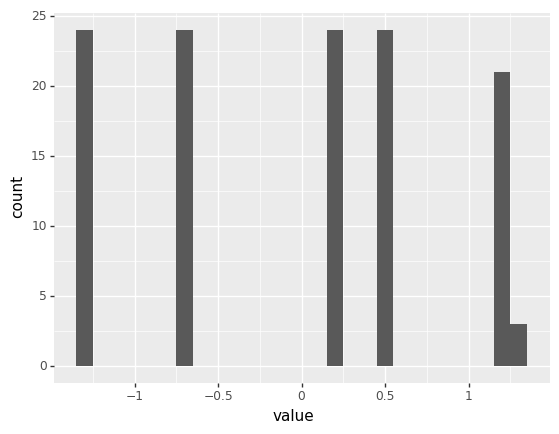

<ggplot: (678783418)>

In [34]:
col = 'dim384'
df = (
    llin_df
    .melt(id_vars=['permutation', 'irrep'])
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .filter(pl.col('variable') == col)
    #.select(['permutation',  col])
)

ggplot(df, aes(x='value')) + geom_histogram(binwidth=0.1)

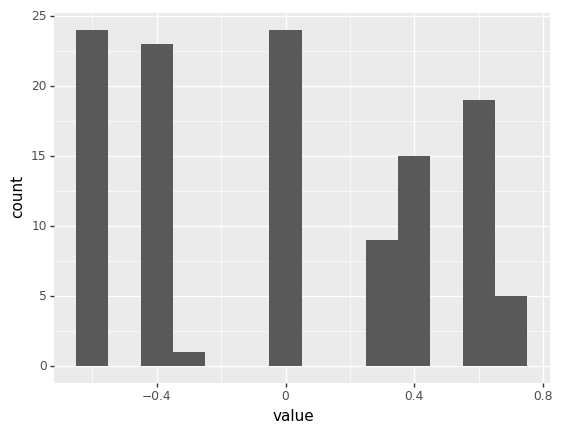

<ggplot: (678337017)>

In [72]:
col = 'dim279'
df = (
    rlin_df
    .melt(id_vars=['permutation', 'irrep'])
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .filter(pl.col('variable') == col)
    #.select(['permutation',  col])
)

ggplot(df, aes(x='value')) + geom_histogram(binwidth=0.1)

In [21]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .arr.eval((pl.element() == element).cast(pl.UInt32))
        .arr.arg_max().cast(pl.Utf8)
    )

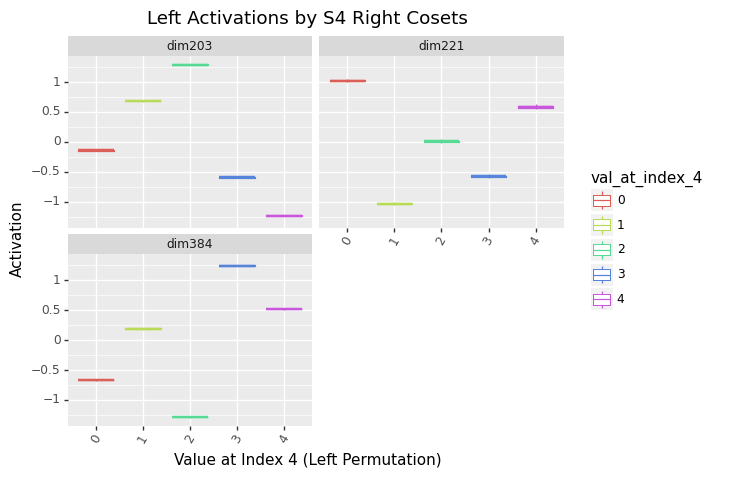

<ggplot: (678997863)>

In [94]:
def make_left_embed_plot(columns, index):
    val_at = f'val_at_index_{index}'
    df = (
        llin_df
        .melt(id_vars=['permutation', 'irrep'])
        .filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .filter(pl.col('variable').is_in(columns))  
        #.select(['permutation', 'irrep', col])
        .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
            pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
            pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
            pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
            pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
            get_index_of('target_vals', '0').alias('index_of_0'),
            get_index_of('target_vals', '1').alias('index_of_1'),
            get_index_of('target_vals', '2').alias('index_of_2'),
            get_index_of('target_vals', '3').alias('index_of_3'),
            get_index_of('target_vals', '4').alias('index_of_4'),
            #pl.col(col).alias('activation')
        ])
        #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
    )
    plot = (
        ggplot(
            df,
            aes(x=val_at, y='value', color=val_at)
        ) 
        + geom_boxplot() 
        + theme(axis_text_x=element_text(rotation=60)) 
        + facet_wrap('~variable', nrow=2)
        + labs(x=f'Value at Index {index} (Left Permutation)', y='Activation')
        + ggtitle(f'Left Activations by S4 Right Cosets')
    )
    return plot

make_left_embed_plot(['dim203', 'dim384', 'dim221'], 4)

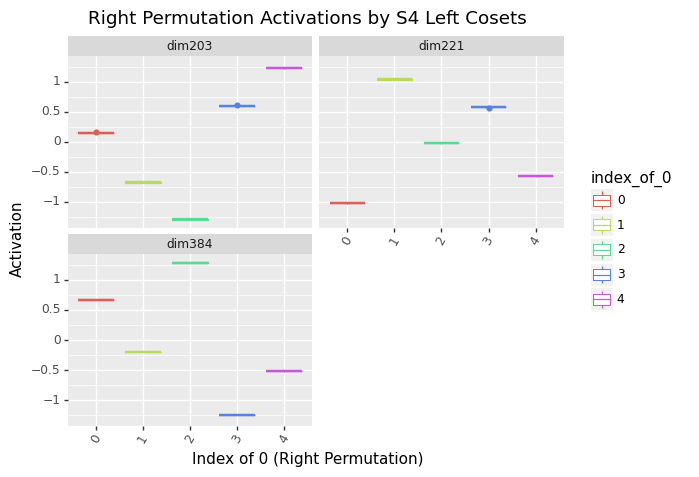

<ggplot: (693885898)>

In [87]:
def make_right_embed_plot(columns, index):
    index_of = f'index_of_{index}'
    df = (
        rlin_df
        .melt(id_vars=['permutation', 'irrep'])
        .filter(pl.col('irrep') == '(2, 1, 1, 1)')
        .filter(pl.col('variable').is_in(columns)) 
        .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
            pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
            pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
            pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
            pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
            get_index_of('target_vals', '0').alias('index_of_0'),
            get_index_of('target_vals', '1').alias('index_of_1'),
            get_index_of('target_vals', '2').alias('index_of_2'),
            get_index_of('target_vals', '3').alias('index_of_3'),
            get_index_of('target_vals', '4').alias('index_of_4'),
            #pl.col(col).alias('activation')
        ])
        #.select(['val_at_index_0', 'val_at_index_1', 'val_at_index_2', 'val_at_index_3', 'val_at_index_4', col])
    )
    plot = (
        ggplot(
            df,
            aes(x=index_of, y='value', color=index_of)
        ) 
        + geom_boxplot()
        + facet_wrap('~variable', nrow=2)
        + theme(axis_text_x=element_text(rotation=60)) 
        + labs(x=f'Index of {index} (Right Permutation)', y='Activation')
        + ggtitle(f'Right Permutation Activations by S4 Left Cosets')
    )
    return plot

make_right_embed_plot(['dim203', 'dim384', 'dim221'], 0)

In [97]:
def mlp(model, )
model.mlp.layers[0].bias

Parameter containing:
tensor([ 1.8453e-02,  7.4229e-03,  2.1576e-02,  4.1275e-04,  1.6942e-02,
        -3.9089e-03,  1.8724e-02,  9.3690e-03,  6.4667e-03,  4.4315e-03,
         1.9390e-02,  2.5448e-02,  1.4594e-02,  1.5310e-02,  1.5942e-03,
         5.4075e-03,  8.3639e-02,  2.4957e-02,  6.4415e-02, -1.3499e-02,
         1.4762e-03, -2.7780e-02,  4.6594e-02,  1.2921e-01,  2.7213e-02,
        -1.7794e-02,  1.0482e-01,  1.5538e-02,  1.1328e-01, -5.8460e-02,
         9.7195e-03,  2.9290e-02,  8.8018e-03,  2.1929e-02,  1.6320e-02,
         2.1808e-02,  3.2221e-03,  5.7409e-03,  1.2775e-02,  1.6456e-02,
         1.1156e-02,  1.2046e-02, -1.6670e-02,  4.2089e-02,  3.8302e-02,
         2.4006e-02,  2.2042e-01,  1.8025e-02,  1.5818e-02,  1.3134e-02,
        -2.9645e-03,  1.6443e-03,  2.3896e-03, -4.2919e-04,  3.4196e-02,
         1.0435e-02,  1.4920e-02,  4.3416e-03,  3.3412e-02, -5.0714e-03,
        -2.0098e-03,  9.3006e-02,  5.7306e-02,  2.5970e-02,  1.5977e-02,
        -1.3165e-02,  6.1352e

In [ ]:
llin_ft = slow_ft_1d(model.lembed.weight @ W0[:, :256].T, 5)
rlin_ft = slow_ft_1d(model.rembed.weight @ W0[:, 256:].T, 5)

llin_fb = sn_fourier_basis(llin_ft, 5)
llin_df = fourier_basis_to_df(llin_fb, 5)

rlin_fb = sn_fourier_basis(rlin_ft, 5)
rlin_df = fourier_basis_to_df(rlin_fb, 5)